# Versuch 8
## Heterogenes Gleichgewicht bei der Zersetzung eines Ammoniakats
Zu Beginn werden alle für die Auswertung notwendigen Module importiert. Welche Module könntet ihr wie üblich für die Auswertung brauchen? Die allgemeinen bereits bekannten und vorausgetzten Python-Kompetenzen könnt ihr unter [Anforderungen.ipynb](Anforderungen.ipynb) nachlesen. Dort sind auch einige Ratschläge bspw. zum Exportieren von Grafiken oder Hinweise zu <code>NumPy</code> aufgeführt.

Falls euch nachträglich Module einfallen, könnt ihr diese jederzeit hier ergänzen. Achtet dabei aber darauf, den entsprechenden Code dann auch erneut auszuführen!

In [1]:
from Hilfsdateien.importe_Bibliotheken import *

Wenn ihr wollt, könnt ihr auch einige für die Auswertung notwendige Naturkonstanten bereits jetzt importieren von <code>scipy.constants</code>. Bedenkt, dass ihr diese Variablennamen nicht erneut nutzen solltet in der Auswertung! Sinnvoll wären z.&nbsp;B. die universelle Gaskonstante $R$, die Standardbeschleunigung $g$ und auch feste Variablen wie Messunsicherheiten können hier definiert werden!

Es ist sinnvoll, bereits jetzt etwaige Konstanten zu definieren, oder Werte für den studentschen $t$-Faktor einzutragen. Achtet wenn notwendig auf die Einheiten!

In [2]:
from Hilfsdateien.importe_Konstanten import *

h_korr = 6
h_delta = 1
T_delta = 0.2

## Erster Auswertungsschritt
Wie üblich wollen wir zunächst alle unsere Messdaten in ein Array einlesen. Mit welchem Befehl geschieht dies üblicherweise? Idealerweise besteht unser Datensatz aus einer Datei, in der eine Spalte die Temperatur und eine Spalte den Druck in mmHg enthält.

In [3]:
#Spalte 0: theta/°C
#Spalte 1: p/mmHg
data = np.genfromtxt("data_v8_real/data.txt",skip_header=1)

Die Höhe im Array muss noch um die Korrekturhöhe $h_\mathrm{korr}$ korrigiert werden. Im Anschluss sollte von mmHg in Pascal oder Bar umgerechnet werden. Außerdem sind wir an der Unsicherheit des umgerechneten Drucks interessiert, es muss also eine Fehlerrechnung durchgeführt werden.

Hierzu wollen wir SymPy nutzen, welches uns ermöglicht eine Funktion $p(h,h_\mathrm{korr})$ zu erstellen und die Ableitungen von $p$ für die Gauß’sche Fehlerfortpflanzung zu ermitteln. Zunächst müssen die Variablen als „Symbole“ für SymPy erstellt werden. Wie könnt ihr dies machen? Nachdem die Ausdrücke definiert haben, müssen diese mittels eines weiteren SymPy-Befehls in aufrufbare Funktionen überführt werden (GIYF, eine [anonyme Funktion](https://de.wikipedia.org/wiki/Anonyme_Funktion) wird oftmals lambda-Funktion genannt!). An diese Funktionen können wir dann die Messwerte und deren Unsicherheiten übergeben und erhalten $p$ bzw. $\Delta p$ als Ergebnis.

In [4]:
#Geht davon aus, dass der Messwert der Säule entsprechend für Torr passt. Andernfalls torr_Pa mit anderem Wert als torr aus scipy.constants ersetzen
h,hkorr,dh,dhkorr = symbols('h h_korr Δh Δh_korr')

pPa = torr_Pa * (h + hkorr)
dpPa = sqrt((diff(pPa,h)*dh)**2 + (diff(pPa,hkorr)*dhkorr)**2)

p_Pa = lambdify([h,hkorr],pPa,'scipy')
dp_Pa = lambdify([h,hkorr,dh,dhkorr],dpPa,'scipy')

p_korr = np.empty((len(data[:,1]),2))
for i in range(len(data[:,1])):
    p_korr[i,:] = p_Pa(data[i,1],h_korr), dp_Pa(data[i,1],h_korr,h_delta,h_delta)
    
print(p_korr/10**2)    

[[139.988   1.885]
 [186.651   1.885]
 [251.979   1.885]
 [338.639   1.885]
 [455.963   1.885]]


## Zweiter Auswertungsschritt
Nun ist eine Auftragung des Drucks $p$ in Millibar gegen die Temperatur $T$ zu erstellen. Achtet wie üblich auf Fehlerbalken, Achsenbeschriftungen, Titel, etc.

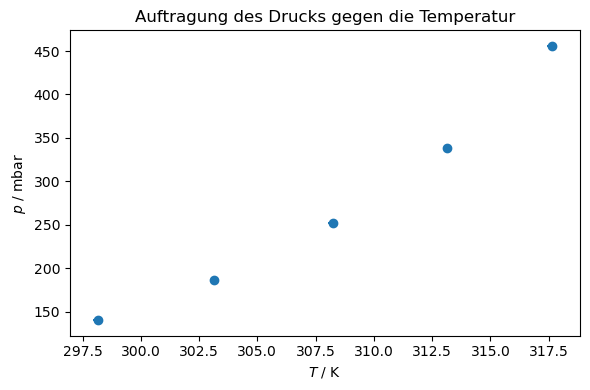

In [5]:
plt.errorbar(data[:,0]+273.15,p_korr[:,0]/10**2,xerr=T_delta,yerr=p_korr[:,1]/10**2,marker='o',ls='None')
plt.xlabel("$T$ / K")
plt.ylabel("$p$ / mbar")
plt.title("Auftragung des Drucks gegen die Temperatur")
plt.tight_layout()
plt.show()
plt.close()

## Dritter Auswertungsschritt
Mittel $p$ kann nun die Standardreaktionsenthalpie $\Delta_\mathrm{R} H^{⦵}$ durch eine linerare Regression bestimmt werden. Die benötigte Gleichung findet ihr im Praktikumsskript.

In [6]:
#Ohne Fehlergewichtung
fit = linregress(1/(data[:,0]+273.15),np.log(p_korr[:,0]/10**5))
print("H")
print("Ohne Fehlergewichtung")
print(np.array2string(np.array([-fit.slope,fit.stderr])*3*R/1000,separator = " +/- ") + " kJ/mol")


#Hier mit SciPy ODR
def f(B, x): 
    return B[0]*x + B[1]
import scipy.odr as odr
linear = odr.Model(f)
h_data = odr.RealData(1/(data[:,0]+273.15),np.log(p_korr[:,0]/10**5), sx=T_delta/(data[:,0]+273.15)**2, sy=p_korr[:,1]/p_korr[:,0])
h_odr = odr.ODR(h_data, linear, beta0=[1,0])
h_output = h_odr.run()
print("Fehlergewichtet nach ODR")
print(np.array2string(np.array([-h_output.beta[0],h_output.sd_beta[0]])*3*R/1000,separator = " +/- ") + " kJ/mol")

H
Ohne Fehlergewichtung
[142.397 +/-   3.61 ] kJ/mol
Fehlergewichtet nach ODR
[144.216 +/-   3.829] kJ/mol


Das Ergebnis der linearen Regressen soll in einer Auftragung gezeigt werden.

[0.013 0.01  0.007 0.006 0.004]


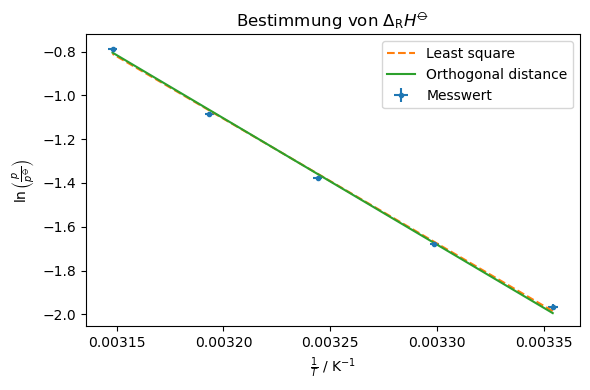

In [7]:
print(p_korr[:,1]/p_korr[:,0])
plt.errorbar(1/(data[:,0]+273.15),np.log(p_korr[:,0]/10**5),xerr=T_delta/(data[:,0]+273.15)**2,yerr=p_korr[:,1]/p_korr[:,0],marker='o',markersize=3,ls="None",label="Messwert")
plt.plot(1/(data[:,0]+273.15),fit.slope*1/(data[:,0]+273.15)+fit.intercept,label="Least square",ls='--')
plt.plot(1/(data[:,0]+273.15),h_output.beta[0]*1/(data[:,0]+273.15)+h_output.beta[1],label="Orthogonal distance")
plt.legend()
plt.xlabel(r"$\frac{1}{T}$ / K$^{-1}$")
plt.ylabel(r"$\ln\left(\frac{p}{p^⦵}\right)$")
plt.title(r"Bestimmung von $\Delta_\mathrm{R} H^{⦵}$")
plt.tight_layout()
plt.show()
plt.close()

## Eigetlich fünfter Auswertungsschritt
Für die nachfolgenden Auswertungsschritte sollte zunächst die isobare Gleichgewichtskonstante $K_p$ ermittelt werden. Stellt hierzu zunächst das Massenwirkungsgesetz auf. Wie setzt sich der Gesamtdruck $p$ jeweils additiv zusammen? Nach der im Skript gegebenen Gleichung
\begin{align}
    K_p = \frac{4}{27}\cdot\left(\frac{p}{p^⦵}\right)^3
\end{align}
ist die Konstante inklusive $\Delta K_p$ zu berechnen. Nutzt erneut SymPy hierzu!

In [8]:
pges,dpges = symbols('p_ges Δp_ges')
Kp = 4/27 * (pges/10**5)**3
dKp = sqrt((diff(Kp,pges)*dpges)**2)

Kp = lambdify([pges],Kp,'scipy')
dKp = lambdify([pges,dpges],dKp,'scipy')

K_p = Kp(p_korr[:,0])
dK_p = dKp(p_korr[:,0],p_korr[:,1])

np.column_stack(np.array([K_p, dK_p]))*10**4

array([[  4.064,   0.164],
       [  9.634,   0.292],
       [ 23.702,   0.532],
       [ 57.532,   0.961],
       [140.438,   1.742]])

## Eigentlich sechster Auswertungsschritt
Nach der Gleichung
\begin{align}
    \Delta_\mathrm{R} G^{⦵} = -R\cdot T_{298}\cdot \ln(K_p)
\end{align}
kann die Standardreaktionsgibbsenergie $\Delta_\mathrm{R} G^{⦵}$ bei 25&nbsp;°C ($T_{298}$) bestimmt werden, $R$ bezeichnet die universelle Gaskonstante. Erledigt dies nun (Fehlerrechnung nicht vergessen!)

In [9]:
#K_p ist "f(p)", daher wird nichts neues in SymPy definiert
#Da Standardbedingungen 298K sind
temp, dtemp = symbols("T ΔT")
G = -R*temp*log(4/27*(pges/10**5)**3)
dG = sqrt((diff(G,pges)*dpges)**2 + (diff(G,temp)*dtemp)**2)

G = lambdify([pges,temp],G,'scipy')
dG = lambdify([pges,temp,dpges,dtemp],dG,'scipy')

gibbs = np.empty((len(data[:,1]),2))
for i in range(len(data[:,1])):
    gibbs[i,:] = G(p_korr[i,0],298), dG(p_korr[i,0],298,p_korr[i,1],0)
print(np.array2string(gibbs/1000,separator=" ± ")+"J/(mol*K)")

[[19.346 ±  0.1  ] ±
 [17.208 ±  0.075] ±
 [14.977 ±  0.056] ±
 [12.78  ±  0.041] ±
 [10.569 ±  0.031]]J/(mol*K)


## Eigentlich vierter Auswertungsschritt
Als letzte thermodynamische Größe fehlt die Reaktionsentropie $\Delta_\mathrm{R} S$. Bestimmt $\Delta_\mathrm{R} S$ und deren Unsicherheit aus einer Auftragung von $R\cdot T\cdot \ln(K_p)$ gegen $T$.

S
LSTQ
[-0.413 ±  0.012] kJ/mol
Fehlergewichtet nach ODR
[-0.427 ±  0.013] kJ/mol


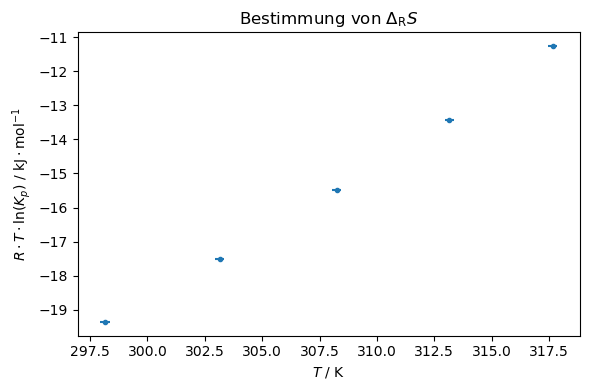

In [13]:
fit2 = linregress(data[:,0]+273.15,-G(p_korr[:,0],data[:,0]+273.15)/1000)
print("S")
print("LSTQ")
print(np.array2string(np.array([-fit2.slope,fit2.stderr]),separator = " ± ") + " kJ/mol")

s_data = odr.RealData(data[:,0]+273.15,-G(p_korr[:,0],data[:,0]+273.15)/1000, sx=T_delta/(data[:,0]+273.15)**2, sy=-dG(p_korr[:,0],data[:,0]+273.15,p_korr[:,1],T_delta)/1000)
s_odr = odr.ODR(s_data, linear, beta0=[1,0])
s_output = s_odr.run()
print("Fehlergewichtet nach ODR")
print(np.array2string(np.array([-s_output.beta[0],s_output.sd_beta[0]]),separator = " ± ") + " kJ/mol")

plt.errorbar(data[:,0]+273.15,-G(p_korr[:,0],data[:,0]+273.15)/1000,xerr=T_delta,marker='o',markersize=3,ls="None")
plt.xlabel("$T$ / K")
plt.ylabel("$R\cdot T\cdot\ln(K_p)$ / $\mathrm{kJ}\cdot\mathrm{mol}^{-1}$")
plt.title("Bestimmung von $\Delta_\mathrm{R} S$")
plt.tight_layout()
plt.show()
plt.close()

## Siebter Auswertungsschritt
Abschließend ist die Zersetzungstemperatur $T_\mathrm{z}$ inklusive Unsicherheit zu ermitteln. Wie müsst ihr hierzu vorgehen?

In [16]:
# T_z = ΔH durch ΔS
# Kann durch Division der Ergebnisse zweier Auftragungen bestimmt werden
# Oder aus den Werten aus der Auftragung von ΔG gegen T mit der Steigung ΔS und dem Schnittpunkt ΔH (T=0). Dabei wird die Abhängigkeit des Schnittpunkts von der Steigung ignoriert, 
# sodass eigtl. Gauß nicht korrekt ist

enth,entr,denth,dentr = symbols('H S ΔH ΔS')

tz = enth/entr
dtz = sqrt((diff(tz,enth)*denth)**2 + (diff(tz,entr)*dentr)**2)

tz = lambdify([enth,entr],tz,'scipy')
dtz = lambdify([enth,entr,denth,dentr],dtz,'scipy')

methode_1 = np.array([tz(-fit.slope*3*R/1000,fit2.slope), dtz(-fit.slope*3*R/1000,fit2.slope,-fit.stderr*3*R/1000,fit2.stderr)])
methode_1_odr = np.array([tz(-h_output.beta[0]*3*R/1000,s_output.beta[0]), dtz(-h_output.beta[0]*3*R/1000,s_output.beta[0],-h_output.sd_beta[0]*3*R/1000,s_output.sd_beta[0])])
#Abhängigkeit vom Schnittpunkt von der Steigung wird hierbei nicht berücksichtigt
methode_2 = np.array([tz(-fit2.intercept,fit2.slope), dtz(-fit2.intercept,fit2.slope,fit2.intercept_stderr,fit2.stderr)])
methode_2_odr = np.array([tz(-s_output.beta[1],s_output.beta[0]), dtz(-s_output.beta[1],s_output.beta[0],-s_output.sd_beta[1],s_output.sd_beta[0])])
print(np.array2string(methode_1,separator=" ± ")+" K")
print(np.array2string(methode_1_odr,separator=" ± ")+" K")
print(np.array2string(methode_2,separator=" ± ")+" K")
print(np.array2string(methode_2_odr,separator=" ± ")+" K")

[344.836 ±  13.177] K
[337.888 ±  13.877] K
[345.387 ±  13.233] K
[344.251 ±  14.575] K


---
Arved Dorst, Göttingen, **2021**.